This notebook explores the data to produce plots for the `Data` section of our report.

1. Number of molecules in each class
1. Distribution of mz's across classes
1. Distribution of motifs across classes

In [70]:
import pandas as pd
import numpy as np

import json
import copy

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [33]:
fname = '../../data/feature_tables/mz_integer.all_scans.txt'
df = pd.read_csv(fname, sep='\t')
df = df.rename(columns={'class': 'mclass'})
df.head()

,0,1,3,4,6,7,8,9,10,11,...,1904,1905,1933,1948,1961,1980,inchi,kingdom,sub_class,mclass
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,ACFIXJIJDZMPPO-NCHANQSKSA-N,Chemical entities,(5'->5')-dinucleotides,"Nucleosides, nucleotides, and analogues;"
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,ACWBBAGYTKWBCD-UHFFFAOYSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,AEMFNILZOJDQLW-QAGGRKNESA-N,Chemical entities,Steroids and steroid derivatives,Lipids and lipid-like molecules;
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,AEMOLEFTQBMNLQ-DTEWXJGMSA-N,Chemical entities,Organooxygen compounds,Organic oxygen compounds;
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,AEMOLEFTQBMNLQ-WAXACMCWSA-N,Chemical entities,Organooxygen compounds,Organic oxygen compounds;


In [44]:
keepclasses = df.groupby('mclass').size().sort_values(ascending=False) > 20
keepclasses = keepclasses[keepclasses].index.tolist() #omg this is the worst: https://stackoverflow.com/questions/17215682/get-indices-that-satisfy-some-criteria
classdf = df.query('mclass == @keepclasses')
classdf.shape

(691, 1535)

In [45]:
## Prepare class plot

# Give each sub class a color
classes = classdf['mclass'].unique()
cls_palette = sns.color_palette('husl', n_colors=len(classes))
lab2color = {classes[i]: cls_palette[i] for i in range(len(classes))}
classdf['class_color'] = classdf['mclass'].apply(lambda x: lab2color[x])

/Users/claire/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [65]:
# Melt to get long-form with mz in one column
meltedclass = pd.melt(classdf.replace(0, np.nan), 
                      id_vars=['inchi', 'kingdom', 'sub_class', 'mclass', 'class_color'],
                      var_name='mz', value_name='intensity')\
                .dropna()

# Sort classes from largest to smallest
meltedclass['mclass'] = meltedclass['mclass'].astype("category")
meltedclass['mclass'].cat.set_categories(keepclasses, inplace=True)
meltedclass = meltedclass.sort_values(by='mclass')
    
meltedclass.head()

,inchi,kingdom,sub_class,mclass,class_color,mz,intensity
81001,KKCIOUWDFWQUBT-AWEZNQCLSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.903599057665, 0.511987276336, 0.195883500602)",119,100.000000
718707,COLNVLDHVKWLRT-QMMMGPOBSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.903599057665, 0.511987276336, 0.195883500602)",1042,0.005005
391877,CVSVTCORWBXHQV-UHFFFAOYSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.903599057665, 0.511987276336, 0.195883500602)",569,0.047047
718109,VVIUBCNYACGLLV-UHFFFAOYSA-N,Chemical entities,Sulfinic acids and derivatives,Organic acids and derivatives;,"(0.903599057665, 0.511987276336, 0.195883500602)",1041,0.001001
718029,CVSVTCORWBXHQV-UHFFFAOYSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.903599057665, 0.511987276336, 0.195883500602)",1041,0.001001


In [67]:
# Add column with x
inchis = meltedclass['inchi'].drop_duplicates().values
inch2x = {inchis[i]: i for i in range(len(inchis))}
meltedclass['x'] = meltedclass['inchi'].apply(lambda x: inch2x[x])
meltedclass.head()

,inchi,kingdom,sub_class,mclass,class_color,mz,intensity,x
81001,KKCIOUWDFWQUBT-AWEZNQCLSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.903599057665, 0.511987276336, 0.195883500602)",119,100.000000,0
718707,COLNVLDHVKWLRT-QMMMGPOBSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.903599057665, 0.511987276336, 0.195883500602)",1042,0.005005,1
391877,CVSVTCORWBXHQV-UHFFFAOYSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.903599057665, 0.511987276336, 0.195883500602)",569,0.047047,2
718109,VVIUBCNYACGLLV-UHFFFAOYSA-N,Chemical entities,Sulfinic acids and derivatives,Organic acids and derivatives;,"(0.903599057665, 0.511987276336, 0.195883500602)",1041,0.001001,3
718029,CVSVTCORWBXHQV-UHFFFAOYSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.903599057665, 0.511987276336, 0.195883500602)",1041,0.001001,2


In [103]:
## Prepare sub_class plot

keepsubclasses = df.groupby('sub_class').size().sort_values(ascending=False) > 15
keepsubclasses = keepsubclasses[keepsubclasses].index.tolist() #omg this is the worst: https://stackoverflow.com/questions/17215682/get-indices-that-satisfy-some-criteria
subclassdf = df.query('sub_class == @keepsubclasses')
subclassdf.shape

# Give each sub class a color
sub_classes = subclassdf['sub_class'].unique()
subcls_palette = sns.color_palette('husl', n_colors=len(sub_classes))
sublab2color = {sub_classes[i]: subcls_palette[i] for i in range(len(sub_classes))}
subclassdf['sub_class_color'] = subclassdf['sub_class'].apply(lambda x: sublab2color[x])

# Melt to get long-form with mz in one column
meltedsubclass = pd.melt(subclassdf.replace(0, np.nan), 
                         id_vars=['inchi', 'kingdom', 'sub_class', 'mclass', 'sub_class_color'],
                         var_name='mz', value_name='intensity')\
                   .dropna()

# Sort sub_classes from largest to smallest
meltedsubclass['sub_class'] = meltedsubclass['sub_class'].astype("category")
meltedsubclass['sub_class'].cat.set_categories(keepsubclasses, inplace=True)
meltedsubclass = meltedsubclass.sort_values(by='sub_class')
    
# Add column with x
subinchis = meltedsubclass['inchi'].drop_duplicates().values
subinch2x = {subinchis[i]: i for i in range(len(subinchis))}
meltedsubclass['x'] = meltedsubclass['inchi'].apply(lambda x: subinch2x[x])
meltedsubclass.head()

/Users/claire/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,inchi,kingdom,sub_class,mclass,sub_class_color,mz,intensity,x
3312,TUHVEAJXIMEOSA-UHFFFAOYSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.967797559292, 0.441274560092, 0.535810315506)",9,100.000000,0
79086,UQTZMGFTRHFAAM-ZETCQYMHSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.967797559292, 0.441274560092, 0.535810315506)",186,0.014014,1
79123,WTDRDQBEARUVNC-LURJTMIESA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.967797559292, 0.441274560092, 0.535810315506)",186,0.003003,2
79164,ZDXPYRJPNDTMRX-VKHMYHEASA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.967797559292, 0.441274560092, 0.535810315506)",186,0.003003,3
79184,AGPKZVBTJJNPAG-WHFBIAKZSA-N,Chemical entities,Carboxylic acids and derivatives,Organic acids and derivatives;,"(0.967797559292, 0.441274560092, 0.535810315506)",187,0.011011,4


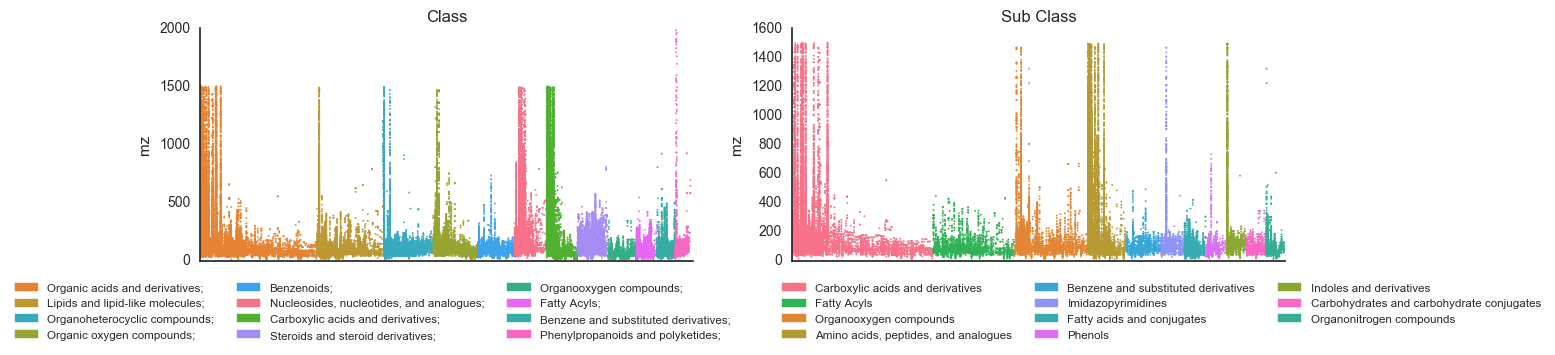

In [129]:
sns.set_style('white')

fig, ax = plt.subplots(1, 2, figsize=(14, 3))

# Class
ax[0].scatter(meltedclass['x'], meltedclass['mz'], 
              color=meltedclass['class_color'], s=1)

lgd_handles = [mpatches.Patch(color=lab2color[k], label=k) 
               for k in meltedclass['mclass'].drop_duplicates().tolist()]
ax[0].legend(handles=lgd_handles, loc='upper center', 
             bbox_to_anchor=(0.35, -0.05), ncol=3,
             fontsize='small')
ax[0].set_ylabel('mz')
ax[0].set_title('Class')

ax[0].set_ylim([0, 2000])
ax[0].set_xlim([0, len(inchis)])
ax[0].set_xticklabels('')
sns.despine(ax=ax[0])

# sub class
ax[1].scatter(meltedsubclass['x'], meltedsubclass['mz'], 
              color=meltedsubclass['sub_class_color'], s=1)

lgd_handles = [mpatches.Patch(color=sublab2color[k], label=k) 
               for k in meltedsubclass['sub_class'].drop_duplicates().tolist()]
ax[1].legend(handles=lgd_handles, loc='upper center', 
             bbox_to_anchor=(0.75, -0.05), ncol=3,
             fontsize='small')
ax[1].set_ylabel('mz')
ax[1].set_title('Sub Class')

ax[1].set_ylim([0, None])
ax[1].set_xlim([0, len(subinchis)])
ax[1].set_xticklabels('')
sns.despine(ax=ax[1])

#plt.savefig('mz_vs_class_and_subclass.png') # actually just did this manually bc plot boundaries...

## Motifs vs classes

In [108]:
fname = '../../data/feature_tables/ms2lda_feature_table.merged_spectra.txt'
df = pd.read_csv(fname, sep='\t')
df = df.rename(columns={'class': 'mclass'})
df.head()

,spec,kingdom,mclass,sub_class,motif_0-overlap,motif_0-prob,motif_1-overlap,motif_1-prob,motif_10-overlap,motif_10-prob,...,motif_95-overlap,motif_95-prob,motif_96-overlap,motif_96-prob,motif_97-overlap,motif_97-prob,motif_98-overlap,motif_98-prob,motif_99-overlap,motif_99-prob
0,FBPFZTCFMRRESA-KVTDHHQDSA-N,Organic compounds,Organooxygen compounds;,Carbohydrates and carbohydrate conjugates,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,VVPRQWTYSNDTEA-UHFFFAOYSA-N,Chemical entities,Lipids and lipid-like molecules;,Fatty Acyls,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PCDQPRRSZKQHHS-XVFCMESISA-N,Chemical entities,Organic oxygen compounds;,Organooxygen compounds,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TVQGDYNRXLTQAP-UHFFFAOYSA-N,Organic compounds,Fatty Acyls;,Fatty acid esters,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FEWJPZIEWOKRBE-JCYAYHJZSA-N,Organic compounds,Organooxygen compounds;,Carbohydrates and carbohydrate conjugates,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
# Melt to eventually create a [motif, prob, overlap]
meltlda = pd.melt(df, id_vars=['spec', 'kingdom', 'mclass', 'sub_class'])
meltlda['motif'] = meltlda['variable'].str.split('-').str[0]
meltlda['motif_n'] = meltlda['motif'].str.split('_').str[1].astype(int)
meltlda['ms2lda_var'] = meltlda['variable'].str.split('-').str[1]

# Keep just the motifs which were present (AKA probability > 0)
meltlda = meltlda.query('ms2lda_var == "prob"')
meltlda = meltlda.query('value > 0')

meltlda.head()

,spec,kingdom,mclass,sub_class,variable,value,motif,motif_n,ms2lda_var
850,VBOQYPQEPHKASR-VKHMYHEASA-N,Chemical entities,Organic acids and derivatives;,Carboxylic acids and derivatives,motif_0-prob,0.002504,motif_0,0,prob
869,RLAWWYSOJDYHDC-BZSNNMDCSA-N,Organic compounds,Carboxylic acids and derivatives;,"Amino acids, peptides, and analogues",motif_0-prob,0.002504,motif_0,0,prob
882,LVRFTAZAXQPQHI-YFKPBYRVSA-N,Chemical entities,Lipids and lipid-like molecules;,Fatty Acyls,motif_0-prob,0.002504,motif_0,0,prob
943,ODHCTXKNWHHXJC-UHFFFAOYSA-N,Organic compounds,Carboxylic acids and derivatives;,"Amino acids, peptides, and analogues",motif_0-prob,0.002504,motif_0,0,prob
950,AEMRFAOFKBGASW-UHFFFAOYSA-N,Chemical entities,Organic acids and derivatives;,Hydroxy acids and derivatives,motif_0-prob,0.002504,motif_0,0,prob


In [130]:
### Get motifs vs class
lda_classes = meltlda.query('mclass == @keepclasses')

# Sort classes from largest to smallest
lda_classes['mclass'] = lda_classes['mclass'].astype("category")
lda_classes['mclass'].cat.set_categories(keepclasses, inplace=True)
lda_classes = lda_classes.sort_values(by='mclass')

# Add color column
lda_classes['class_color'] = lda_classes['mclass'].apply(lambda x: lab2color[x])

# And x column - note there are 3 more spectra in this df than in the one above... why?
inchis = lda_classes['spec'].drop_duplicates().values
inch2x = {inchis[i]: i for i in range(len(inchis))}
lda_classes['x'] = lda_classes['spec'].apply(lambda x: inch2x[x])

### And motifs vs sub_class
lda_subclasses = meltlda.query('sub_class == @keepsubclasses')

# Sort classes from largest to smallest
lda_subclasses['sub_class'] = lda_subclasses['sub_class'].astype("category")
lda_subclasses['sub_class'].cat.set_categories(keepsubclasses, inplace=True)
lda_subclasses = lda_subclasses.sort_values(by='sub_class')

# Add color column
lda_subclasses['subclass_color'] = lda_subclasses['sub_class'].apply(lambda x: sublab2color[x])

# And x column - note there are 3 more spectra in this df than in the one above... why?
subinchis = lda_subclasses['spec'].drop_duplicates().values
subinch2x = {subinchis[i]: i for i in range(len(subinchis))}
lda_subclasses['x'] = lda_subclasses['spec'].apply(lambda x: subinch2x[x])


/Users/claire/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/claire/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


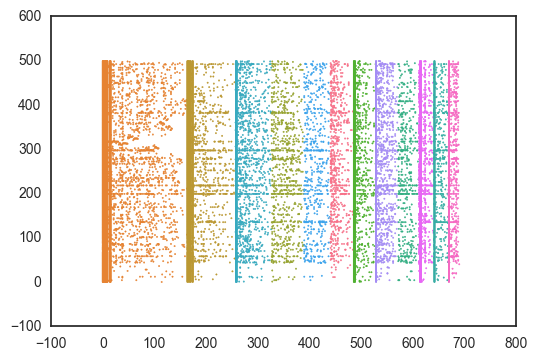

In [126]:
plt.scatter(lda_classes['x'], lda_classes['motif_n'], color=lda_classes['class_color'], s=1)

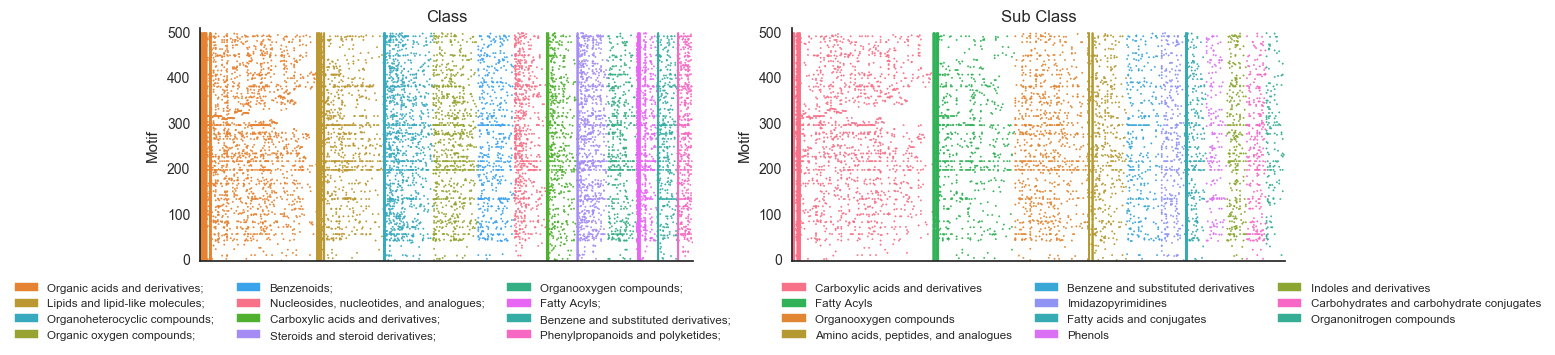

In [135]:
sns.set_style('white')

fig, ax = plt.subplots(1, 2, figsize=(14, 3))

# Class
ax[0].scatter(lda_classes['x'], lda_classes['motif_n'], 
              color=lda_classes['class_color'], s=1)

lgd_handles = [mpatches.Patch(color=lab2color[k], label=k) 
               for k in lda_classes['mclass'].drop_duplicates().tolist()]
ax[0].legend(handles=lgd_handles, loc='upper center', 
             bbox_to_anchor=(0.35, -0.05), ncol=3,
             fontsize='small')
ax[0].set_ylabel('Motif')
ax[0].set_title('Class')

ax[0].set_ylim([0, 510])
ax[0].set_xlim([0, len(inchis)])
ax[0].set_xticklabels('')
sns.despine(ax=ax[0])

# sub class
ax[1].scatter(lda_subclasses['x'], lda_subclasses['motif_n'], 
              color=lda_subclasses['subclass_color'], s=1)

lgd_handles = [mpatches.Patch(color=sublab2color[k], label=k) 
               for k in lda_subclasses['sub_class'].drop_duplicates().tolist()]
ax[1].legend(handles=lgd_handles, loc='upper center', 
             bbox_to_anchor=(0.75, -0.05), ncol=3,
             fontsize='small')
ax[1].set_ylabel('Motif')
ax[1].set_title('Sub Class')

ax[1].set_ylim([0, 510])
ax[1].set_xlim([0, len(subinchis)])
ax[1].set_xticklabels('')
sns.despine(ax=ax[1])

#plt.savefig('motifs_vs_class_and_subclass.png') # actually just did this manually bc plot boundaries...